Authors: Zhewei Yao <https://github.com/yaozhewei>, Amir Gholami <http://amirgholami.org/>


This tutorial shows how to compute the Hessian information using (randomized) numerical linear algebra for both explicit Hessian (the matrix is given) as well as implicit Hessian (the matrix is ungiven).

We'll start by doing the necessary imports:

In [1]:
import numpy as np
import torch 
from torchvision import datasets, transforms
from pyhessian import hessian # Hessian computation
from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

import sys
sys.path.append('../')
from lean.models import get_model

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib ipympl

In [2]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def getData(name='cifar10', max_train_samples=0, train_bs=128, test_bs=1000):
    """
    Get the dataloader
    """
    if name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        trainset = datasets.CIFAR10(root='../data',
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        
        if max_train_samples: 
            # create shuffled indices
            rand_sub_ind = np.array(list(range(0, len(trainset))))
            np.random.shuffle(rand_sub_ind)
            rand_sub_ind = rand_sub_ind[:max_train_samples]
            # select shuffled subset
            trainset = torch.utils.data.Subset(trainset, rand_sub_ind)
        
        train_loader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=train_bs,
                                                   shuffle=True)

        testset = datasets.CIFAR10(root='../data',
                                   train=False,
                                   download=False,
                                   transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset,
                                                  batch_size=test_bs,
                                                  shuffle=False)
    if name == 'cifar10_without_dataaugmentation':
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        trainset = datasets.CIFAR10(root='../data',
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=train_bs,
                                                   shuffle=True)

        testset = datasets.CIFAR10(root='../data',
                                   train=False,
                                   download=False,
                                   transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset,
                                                  batch_size=test_bs,
                                                  shuffle=False)

    return train_loader, test_loader


def test(model, test_loader, cuda=True):
    """
    Get the test performance
    """
    model.eval()
    correct = 0
    total_num = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        pred = output.data.max(
            1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        total_num += len(data)
    print('testing_correct: ', correct / total_num, '\n')
    return correct / total_num

## Example 2: Power Iteration for NN Hessian

In [4]:
from deepee import ModelSurgeon
from deepee.surgery import SurgicalProcedures
from functools import partial
surgeon = ModelSurgeon(partial(SurgicalProcedures.BN_to_GN, num_groups=8))

In [5]:
# get the model 
def get_model_simple(
    architecture = 'smoothnet',
    cuda = True,
):
    # def get_model(
    #     model_name, 
    #     pretrained, 
    #     num_classes, 
    #     data_name, 
    #     kernel_size, 
    #     conv_layers,
    #     nr_stages, 
    #     depth, 
    #     width,
    #     halve_dim, 
    #     after_conv_fc_str, 
    #     activation_fc_str,
    #     skip_depth,
    #     dense,
    #     dsc
    # )

    if architecture=='densenet':
        model=get_model("densenet121", False, 10, "cifar10", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        model = surgeon.operate(model)
        dense_dict = torch.load("./trained_models/CIFAR10_models/densenet121_gn_8_imagenette_eps7.pt")
        dense_dict = {k.replace("_module.", ""):v for k,v in dense_dict.items()}
        model.load_state_dict(dense_dict)
    elif architecture == 'smoothnet':
        model = get_model('en_scaling_residual_model', False, 10, 'cifar10', 3, [16, 32], 1, 5, 8, True, 'mxp_gn', 'selu', 2, True, False)
        smooth_dict = {k.replace("_module.", ""):v for k,v in torch.load("./trained_models/CIFAR10_models/smoothnetw80d50_cifar10_180e_eps7.pt", map_location='cpu').items()}
        model.load_state_dict(smooth_dict) 
    elif architecture=='resnet34':
        model=get_model("resnet34", False, 10, "cifar10", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        model = surgeon.operate(model)
        model.fc = torch.nn.Linear(512, 10)
        res_dict = torch.load("/home/alex/DPBenchmark/resnet34_gn8_imagenette_eps7.pt")
        res_dict = {k.replace("_module.", ""):v for k,v in res_dict.items()}
        model.load_state_dict(res_dict)
    elif architecture=='efficientnetb0':
        import timm
        model = timm.create_model("efficientnet_b0")
        # model=get_model("efficientnet_b0", False, 10, "cifar10", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        # NOTE: b0 was 1280, b3 was 1536, b5 was 2048, b7 was 2560
        model.classifier = torch.nn.Linear(1280, 10)
        model = surgeon.operate(model)
        eff_dict = torch.load("efficientb0_gn8_imagenette_eps7.pt")
        eff_dict = {k.replace("_module.", ""):v for k,v in eff_dict.items()}
        model.load_state_dict(eff_dict)
    return model


In [6]:
cuda = True
model = get_model_simple("smoothnet", cuda)

You're using dense connections => halve_dim=False and skip_depth=0


In [7]:
# load in important tensors if already calculated
top_eigenvalues = torch.load("smoothnet_evals.pt")
top_eigenvector = torch.load("smoothnet_evecs.pt")
Z = torch.load("smoothnet_5_30_loss.pt") # loaded in as numpy array

In [8]:
# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData(max_train_samples=4096, train_bs=512)

# NOTE: in case we only want to use a single batch and not work with the data loader
# for inputs, targets in train_loader:
#     break

# # we use cuda to make the computation fast
# if cuda:
#     model = model.cuda()
#     inputs, targets = inputs.cuda(), targets.cuda()

# # create the hessian computation module 
# hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=cuda)


Files already downloaded and verified


In [7]:
# create the hessian computation module 
hessian_comp = hessian(model.cuda() if cuda else model, criterion, dataloader=train_loader, cuda=cuda)

In [8]:
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2, maxIter=100)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: 4216.4155 6371.9419


In [9]:
torch.save(top_eigenvalues, 'smoothnet_evals.pt')
torch.save(top_eigenvector, 'smoothnet_evecs.pt')

The small difference between this top eigenvalue (195.4954) and the previous one (195.5897) is due to the small number of iterations that we used in Power iteration. You can remove this small difference by increasing the number of iterations for power iteration.

## Example 2.1: Plot Loss Landscape

We can use the Hessian eigenvectors/eigenvalues to analyze the flat/sharpness of the loss landscape of your model, and plot the loss landscape. We will show that this can be more informative than using random directions.

To plot the loss landscape, we first compute the top Hessian eigenvector and then perturb the model parameters along that direction and measure the loss.

In [ ]:
# get the top eigenvector
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()

In [86]:

from copy import deepcopy
from torch import nn

def get_params(model_orig,  model_pert, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_pert.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_pert

# TODO: WIP for a more efficient parallel evaluation
# def get_params(model_orig,  model_pert_temp, direction, alphas):
#     models = []
#     for alpha in alphas:
#         model_pert = deepcopy(model_pert_temp)
#         for m_orig, m_perb, d in zip(model_orig.parameters(), model_pert.parameters(), direction):
#             m_perb.data = m_orig.data + alpha * d
#         models.append(model_pert)
#     return nn.ModuleList(models)

# def calc_pert_loss(pert_amount, train_loader, criterion, model, model_pert, direction): 
#     model_pert = get_params(model, model_pert, direction, torch.from_numpy(pert_amount))
#     loss_agg = 0
#     for inputs, targets in train_loader:
#         batch_size = inputs.shape[0]
#         inputs, targets = inputs.cuda().repeat(len(model_pert)), targets.cuda().repeat(len(model_pert))
#         preds = torch.nn.parallel.parallel_apply(
#             self.models, torch.stack(x.split(batch_size))  # type: ignore
#         )
#         loss_agg += criterion(preds, targets).item()
#     return loss_agg

You're using dense connections => halve_dim=False and skip_depth=0


Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

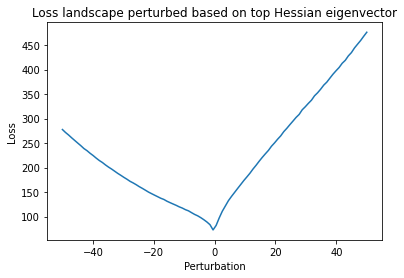

In [89]:
import functools

# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-50, 50, 100).astype(np.float32)

loss_list = []

# create a copy of the model
model_pert = get_model_simple("smoothnet", True)
model_pert.eval()
model_pert = model_pert.cuda()

# TODO: more efficient perturbation calculation - WIP.
# calc_pert_loss_init = functools.partial(
#     calc_pert_loss, 
#     train_loader=train_loader,
#     criterion=criterion,
#     model=model,
#     model_pert=model_pert,
#     direction=top_eigenvector[0],
# )
# loss_list = np.apply_along_axis(calc_pert_loss_init, 0, lams)

# NOTE: the unefficient way of calculating
for lam in lams:
    model_pert = get_params(model, model_pert, top_eigenvector[0], lam)
    loss_agg = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        loss_agg += criterion(model_pert(inputs), targets).item()
    loss_list.append(loss_agg)

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

In [71]:
# now the same in 3D
def get_3D_params(model_orig,  model_pert, direction1, direction2, alpha1, alpha2):
    for m_orig, m_perb, d1, d2 in zip(model_orig.parameters(), model_pert.parameters(), direction1, direction2):
        m_perb.data = m_orig.data + alpha1 * d1 + alpha2 * d2
    return model_pert

You're using dense connections => halve_dim=False and skip_depth=0
You're using dense connections => halve_dim=False and skip_depth=0


Text(0.5, 0, '')

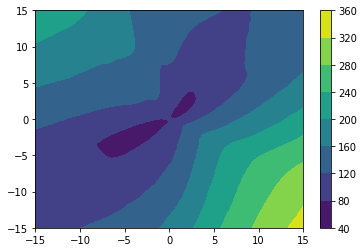

In [75]:
import matplotlib.pyplot as plt

# create a copy of the model
model = get_model_simple("smoothnet", True)
model.eval()
model = model.cuda()
model_pert = get_model_simple("smoothnet", True)
model_pert.eval()
model_pert = model_pert.cuda()

lams_x = np.linspace(-15, 15, 50).astype(np.float32)
lams_y = np.linspace(-15, 15, 50).astype(np.float32)
X, Y = np.meshgrid(lams_x, lams_y)
Z = np.zeros_like(X)

for i, lam1 in enumerate(lams_x):
    for j, lam2 in enumerate(lams_y):
        model_pert = get_3D_params(model, model_pert, top_eigenvector[0], top_eigenvector[1], lam1, lam2)
        for inputs, targets in train_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            Z[i, j] += criterion(model_pert(inputs), targets).item()

fig,ax = plt.subplots(1, 1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title("")
ax.set_ylabel("")
ax.set_xlabel("")

In [76]:
# takes also long to calculate so better save 
torch.save(Z, "smoothnet_15_50_loss.pt")

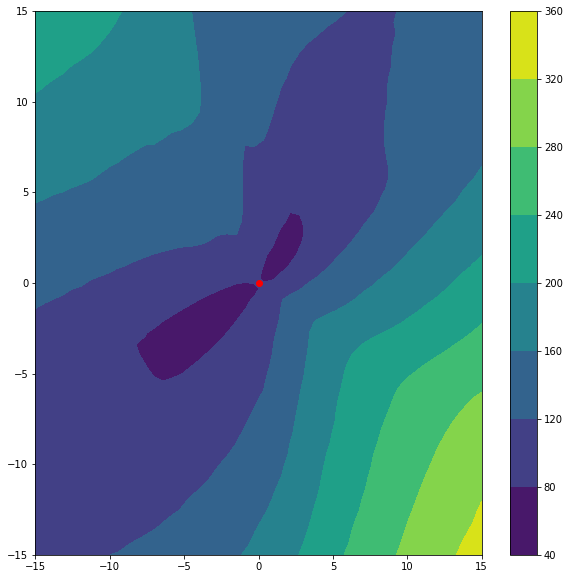

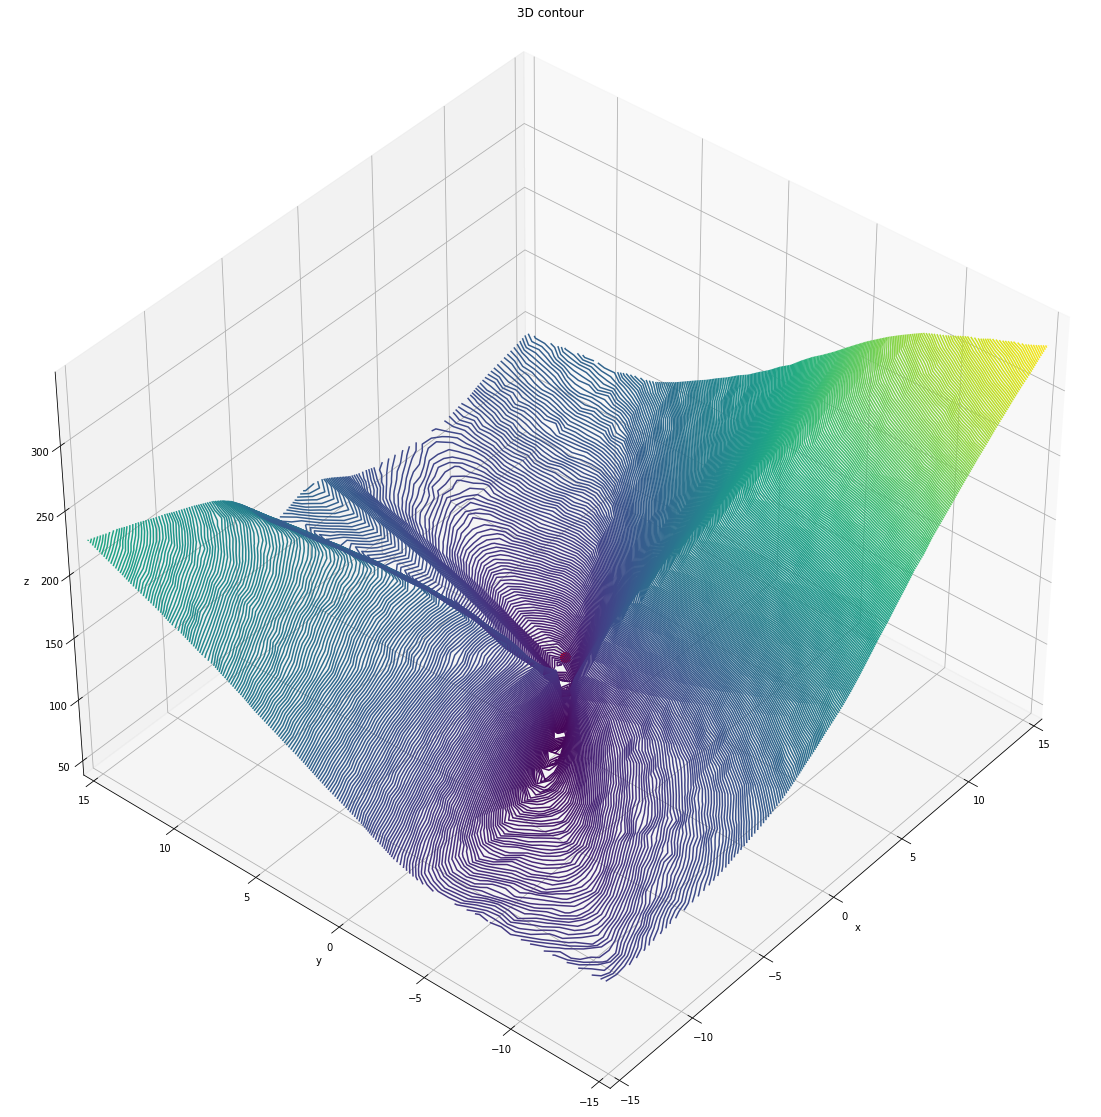

In [84]:
lams_x = np.linspace(-15, 15, 50).astype(np.float32)
lams_y = np.linspace(-15, 15, 50).astype(np.float32)
X, Y = np.meshgrid(lams_x, lams_y)

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title("")
ax.set_ylabel("")
ax.set_xlabel("")
ax.scatter(0, 0, c='red')

fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.view_init(40, -140)
ax.contour3D(X, Y, Z, 400, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])

ax.set_title('3D contour')
ax.scatter(0, 0, Z[0, 0], s=100, c='red')

Now let's compare this with a loss landscape computed based on perturbing the model parameters along a random direction.

In [ ]:
from pyhessian.utils import normalization

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
v = normalization(v)


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_pert = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_pert.eval()
model_pert = model_pert.cuda()

for lam in lams: 
    model_pert = get_params(model, model_pert, v, lam)
    loss_list.append(criterion(model_pert(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on a random direction')

Note how different the loss landscape looks. In particular note that there is almost no change in the loss value (see the small scale of the y-axis). This is expected, since for a converged NN, many of the directions are typically degenarate (i.e. they are flat).

We can also use gradient direction to perturb the model. While gradient is better than random vector, but it is not possible to use it to plot 3D loss landscape since you will need more than one direction. However, you can use top 2 Hessian vectors instead for that scenario.

In [ ]:
from pyhessian.utils import normalization


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_pert = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_pert.eval()
model_pert = model_pert.cuda()

# generate gradient vector to do the loss plot
loss = criterion(model_pert(inputs), targets)
loss.backward()

v = [p.grad.data for p in model_pert.parameters()]
v = normalization(v)
model_pert.zero_grad()


for lam in lams: 
    model_pert = get_params(model, model_pert, v, lam)
    loss_list.append(criterion(model_pert(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on gradient direction')

Now let's repeate the above for computing the trace and diagonal of Hessian for ResNet20.

In [ ]:


# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData(train_bs=1000)

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
cuda=False
if cuda:
    model = model.cuda()
    inputs, targets = inputs.cuda(), targets.cuda()

In [ ]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=cuda)

In [ ]:
trace = hessian_comp.trace(maxIter=100) # 100 is default
print("The trace of this model is: %.4f"%(np.mean(trace)))

We can also get the full eigenvalue spectrum density of Hessian using Stochastic Lancoz algorithm.

In [ ]:
density_eigen, density_weight = hessian_comp.density()

In [ ]:
get_esd_plot(density_eigen, density_weight)

The above ESD plot is very interesting and shows that a lot of the eigenvalues of the Hessian are close to zero. This means that a lot of the directions along the loss landscape is almost flat. We expect this based on the loss landscape that we got above when we used a random direction. Another interesting observation is that there are several large Hessian outliers. The other very interesting finding, is that there are a lot of directions with slight negative curvature. This means that we still have not converged to a perfect local minimum that satisfies first and second order optimality conditions.